<a href="https://colab.research.google.com/github/Skander28/LastWork/blob/main/NewMarbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyarabic
!pip install optuna==2.3.0
!pip uninstall -y transformers accelerate
!pip install transformers accelerate
!pip install tokenizers==0.9.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 15.6 MB/s eta 0:00:00
  Created wheel for optuna: filename=optuna-2.3.0-py3-none-any.whl size=359702 sha256=89b96b90d49cd3af5e11321be7bcaa463ed46e0c4c567326714867d2324d40ce
  Stored 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import pyarabic.araby as ar
import re, functools, operator, string
import optuna, gc, random, os  
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score, roc_curve , auc
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from sklearn.utils import resample
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [3]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.  

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
    
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon May 29 09:01:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [4]:

from google.colab import drive
drive.mount('/content/drive')
     
import pandas as pd
filtered_df = pd.read_csv('/content/drive/MyDrive/Thisone.csv',lineterminator='\n')
     


Mounted at /content/drive


In [5]:
# a class representing the dataset
class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [6]:
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTModelDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
  
    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
    
      encoded_review = self.tokenizer.encode_plus(
      text,
      max_length= self.max_len,
      add_special_tokens= True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt'
    )
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)

      return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

In [7]:
# def data_cleaning (text):
#   try:
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(r"https\S+", "", text)
#     text = re.sub(r'\s+', ' ', text)
#     text = re.sub("(\s\d+)","",text) 
#     text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
#     text = re.sub("\d+", " ", text)
#     text = ar.strip_tashkeel(text)
#     text = ar.strip_tatweel(text)
#     text = text.replace("#", " ");
#     text = text.replace("@", " ");
#     text = text.replace("_", " ");
#     translator = str.maketrans('', '', string.punctuation)
#     text = text.translate(translator)
#     text = text.replace("آ", "ا")
#     text = text.replace("إ", "ا")
#     text = text.replace("أ", "ا")
#     text = text.replace("ؤ", "و")
#     text = text.replace("ئ", "ي")
#   except:
#     return text
   
#   return text

In [8]:
# # Cleaning Training Data 
# filtered_df['tweets'] = filtered_df['tweets'].apply(lambda x:   data_cleaning(x))

In [9]:
Extra_Len = 6 # an extra padding in length , found to be useful for increasing F-score
Max_Len = filtered_df["text"].str.split().str.len().max() + Extra_Len

print(Max_Len)

#Spliting the Training data
Test_Size = 0.05
Rand_Seed = 42 

# Split original data into train and test sets
train_set, test_set = train_test_split(filtered_df, test_size=Test_Size, random_state=Rand_Seed )

# Split training data into train and validation sets
train_set, evaluation_set = train_test_split(train_set, test_size=Test_Size, random_state=Rand_Seed)

print("Train set: ")
print(train_set["dialect"].value_counts())
print("---------------------------")
print ("Evaluation set: ")
print (evaluation_set["dialect"].value_counts())
print("---------------------------")
print ("test set: ")
print (test_set["dialect"].value_counts())

93
Train set: 
DZ    16283
TN    16260
LY    16251
MA    16210
Name: dialect, dtype: int64
---------------------------
Evaluation set: 
MA    866
TN    862
DZ    860
LY    834
Name: dialect, dtype: int64
---------------------------
test set: 
MA    931
LY    922
TN    885
DZ    864
Name: dialect, dtype: int64


In [10]:
Model_Used = "UBC-NLP/MARBERT"
Task_Name = "classification"

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map))

def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids, preds))
    print(confusion_matrix(p.label_ids, preds))

    test_confusion_matrix = confusion_matrix(p.label_ids, preds, labels=[0, 1, 2, 3])
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(['LY', 'DZ', 'MA', 'TN'], fontsize=12)
    ax.set_yticklabels(['LY', 'DZ', 'MA', 'TN'], fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    macro_f1_pos_neg = f1_score(p.label_ids, preds, average='macro', labels=[1, 2])
    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    macro_precision = precision_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')
    acc = accuracy_score(p.label_ids, preds)

    num_classes = len(np.unique(p.label_ids))

#     if num_classes == 2:
#         # Binary classification case
#         label_pos = np.where(np.unique(p.label_ids) == 1)[0][0]
#         probabilities = p.predictions[:, label_pos]  # Use the probability of the positive class
#         fpr, tpr, _ = roc_curve(p.label_ids, probabilities)
#         roc_auc = auc(fpr, tpr)

#         plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver Operating Characteristic')
#         plt.legend(loc='lower right')
#         plt.show()

#         return {
#             'macro_f1': macro_f1,
#             'macro_f1_pos_neg': macro_f1_pos_neg,
#             'macro_precision': macro_precision,
#             'macro_recall': macro_recall,
#             'accuracy': acc,
#             'roc_auc': roc_auc,
#             'roc_curve': (fpr, tpr),
#         }
#     else:
        # Multiclass classification case
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_label in range(num_classes):
        probabilities = p.predictions[:, class_label]
        fpr[class_label], tpr[class_label], _ = roc_curve(
            p.label_ids, probabilities, pos_label=class_label
        )
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

    for class_label in range(num_classes):
        plt.plot(fpr[class_label], tpr[class_label],
                 label='ROC curve of class %d (area = %0.2f)' % (class_label, roc_auc[class_label]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
  
    return {
        'macro_f1': macro_f1,
        'macro_f1_pos_neg': macro_f1_pos_neg,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': acc
  }

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [11]:
label_list = list(train_set["dialect"].unique())
#sentence_list = ['DZ', 'TN', 'MA', 'LY']
#ew_label_list = [sentence_list[label] for label in label_list]
print(label_list)
print(train_set["dialect"].value_counts())

data_set = Dataset( "OLY", train_set, evaluation_set, label_list )

# Define the list of class names
#label_list = ['DZ', 'TN', 'MA', 'LY']

# Create a label map that maps class names to their corresponding indices
label_map = {v: i for i, v in enumerate(label_list)}

# Print the label map
print(label_map)

train_dataset = BERTModelDataset(train_set["text"].to_list(),
                                 train_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

evaluation_dataset = BERTModelDataset(evaluation_set["text"].to_list(),
                                      evaluation_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

test_dataset = BERTModelDataset(test_set["text"].to_list(),
                                      test_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

['LY', 'DZ', 'MA', 'TN']
DZ    16283
TN    16260
LY    16251
MA    16210
Name: dialect, dtype: int64
{'LY': 0, 'DZ': 1, 'MA': 2, 'TN': 3}


In [12]:
#define training arguments
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-8 
training_args.learning_rate = 2e-05
training_args.fp16 = True
training_args.per_device_train_batch_size = 64
training_args.per_device_eval_batch_size = 32
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 4
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.seed = 42 
training_args.disable_tqdm = False

In [13]:
training_args.dataloader_pin_memory = False
gc.collect()
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset= evaluation_dataset,
    compute_metrics=compute_metrics
)



print(training_args.seed)

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

42


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy
1,0.666800,0.472208,0.820058,0.809194,0.820838,0.820708,0.820281
2,0.321500,0.387710,0.863912,0.861207,0.866222,0.863427,0.863530
3,0.156100,0.398163,0.880469,0.876286,0.882618,0.880127,0.880479
4,0.085900,0.404514,0.885992,0.882923,0.886289,0.885935,0.886032


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       834
           1       0.79      0.78      0.78       860
           2       0.83      0.84      0.83       866
           3       0.85      0.79      0.82       862

    accuracy                           0.82      3422
   macro avg       0.82      0.82      0.82      3422
weighted avg       0.82      0.82      0.82      3422

[[733  43  29  29]
 [ 61 668  79  52]
 [ 35  67 728  36]
 [ 75  64  45 678]]


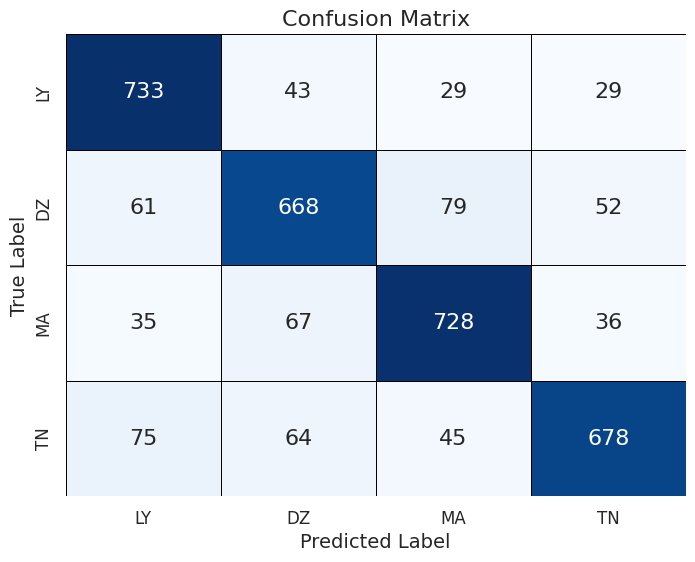

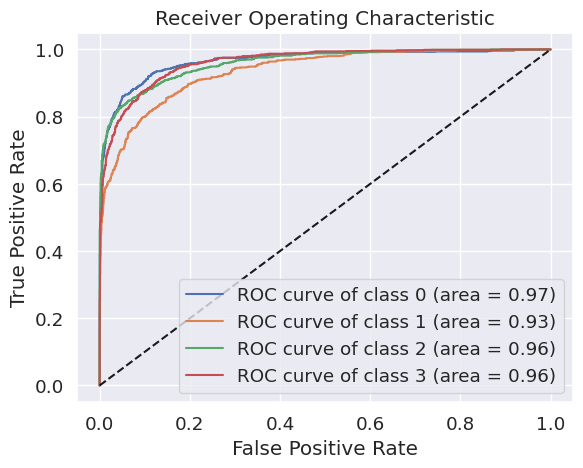

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       834
           1       0.84      0.84      0.84       860
           2       0.91      0.86      0.88       866
           3       0.82      0.90      0.86       862

    accuracy                           0.86      3422
   macro avg       0.87      0.86      0.86      3422
weighted avg       0.87      0.86      0.86      3422

[[710  44  19  61]
 [ 30 725  34  71]
 [ 22  60 742  42]
 [ 26  38  20 778]]


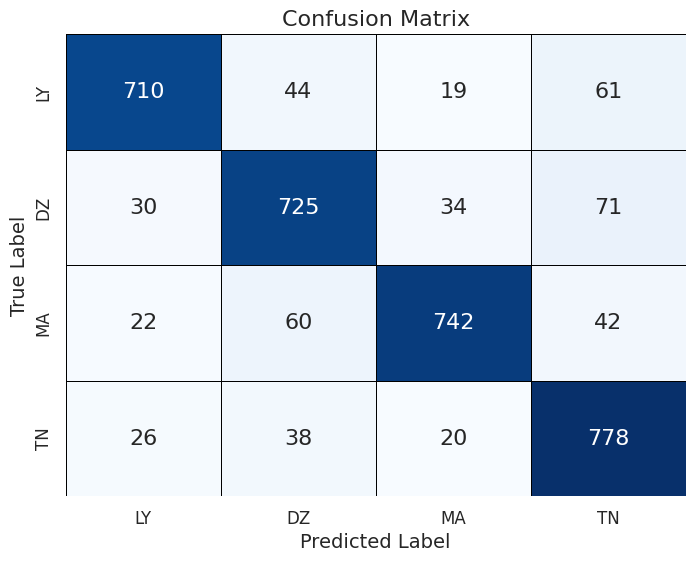

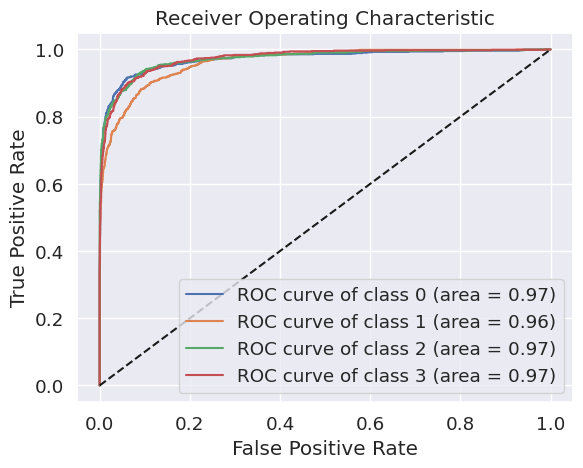

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       834
           1       0.85      0.86      0.85       860
           2       0.89      0.90      0.90       866
           3       0.85      0.92      0.89       862

    accuracy                           0.88      3422
   macro avg       0.88      0.88      0.88      3422
weighted avg       0.88      0.88      0.88      3422

[[702  49  24  59]
 [ 19 737  48  56]
 [ 12  51 780  23]
 [ 21  27  20 794]]


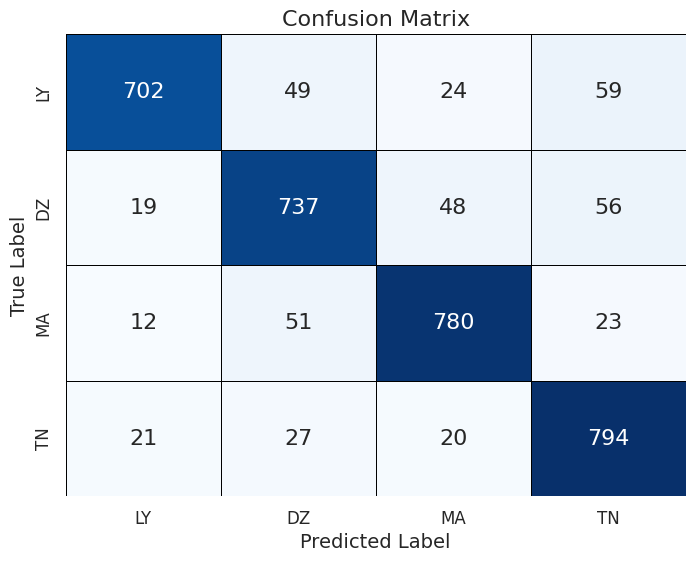

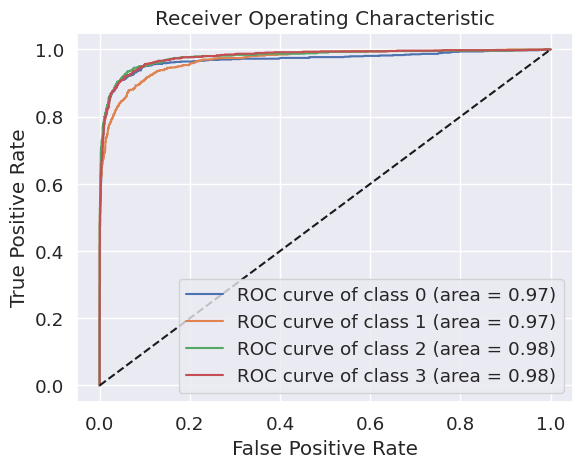

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       834
           1       0.86      0.86      0.86       860
           2       0.91      0.90      0.90       866
           3       0.88      0.91      0.89       862

    accuracy                           0.89      3422
   macro avg       0.89      0.89      0.89      3422
weighted avg       0.89      0.89      0.89      3422

[[732  38  20  44]
 [ 35 739  36  50]
 [ 20  51 777  18]
 [ 31  28  19 784]]


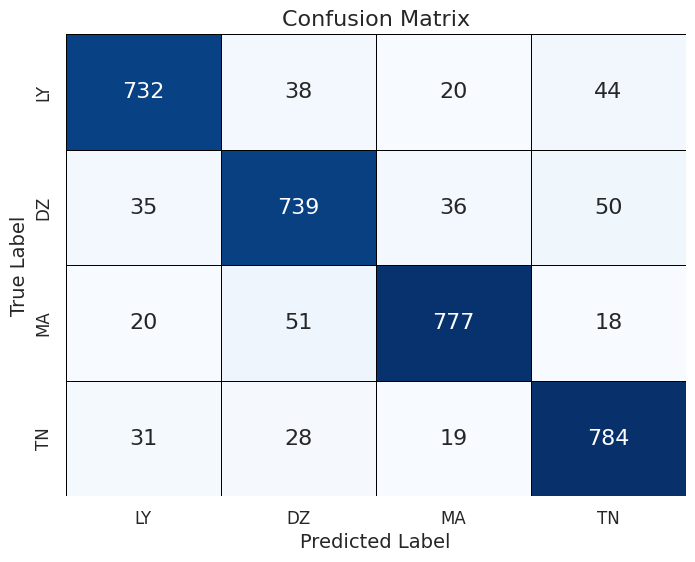

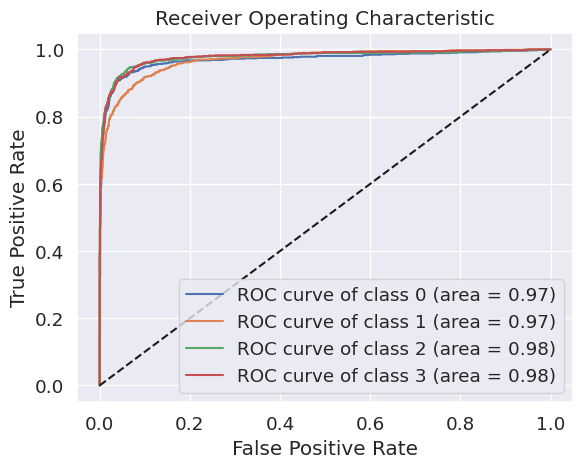

TrainOutput(global_step=2032, training_loss=0.3041384338628589, metrics={'train_runtime': 1458.2477, 'train_samples_per_second': 178.307, 'train_steps_per_second': 1.393, 'total_flos': 1.2426818513675904e+16, 'train_loss': 0.3041384338628589, 'epoch': 4.0})

In [14]:

import os
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       922
           1       0.83      0.86      0.85       864
           2       0.91      0.89      0.90       931
           3       0.89      0.93      0.91       885

    accuracy                           0.89      3602
   macro avg       0.89      0.89      0.89      3602
weighted avg       0.89      0.89      0.89      3602

[[798  57  27  40]
 [ 40 743  41  40]
 [ 14  63 833  21]
 [ 21  28  12 824]]


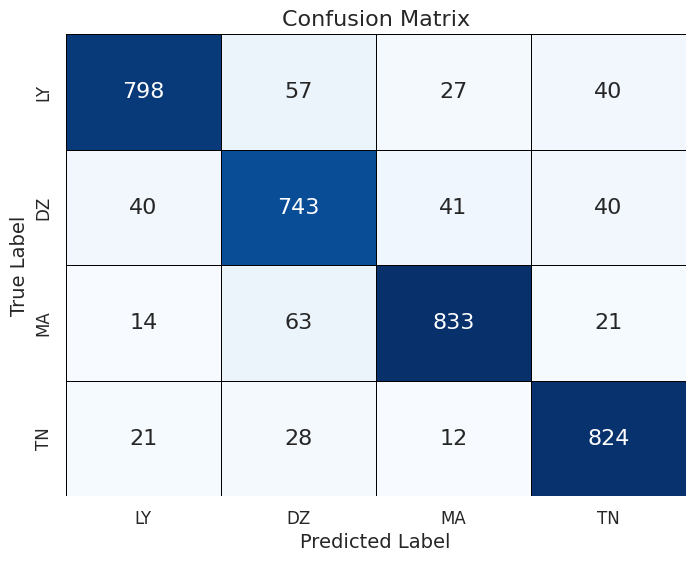

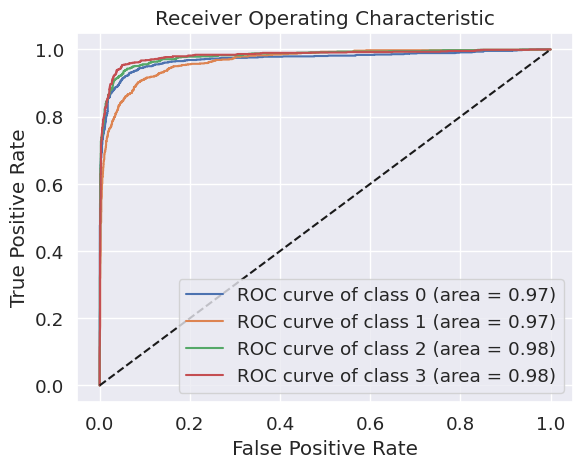

{'test_loss': 0.3996736705303192, 'test_macro_f1': 0.8874570225946362, 'test_macro_f1_pos_neg': 0.875097181279394, 'test_macro_precision': 0.8877928595744187, 'test_macro_recall': 0.8878184383812342, 'test_accuracy': 0.8878400888395336, 'test_runtime': 7.8546, 'test_samples_per_second': 458.585, 'test_steps_per_second': 14.386}


In [15]:
# Evaluate test set
test_results = trainer.predict(test_dataset)

# Print test set results
print(test_results.metrics)

In [16]:
# import torch
# from transformers import AutoTokenizer, BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained(Model_Used, num_labels=4).to(device)

# # Load the trained model from disk
# model_state_dict = torch.load('/content/trainer.pth')
# model.load_state_dict(model_state_dict)

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(Model_Used)



# # Tokenize the input sentence
# #input_sentence = "نبي نروح للحوش "
# #input_sentence = 'واش دير للعشى'
# #input_sentence  = "شوكران علا هاد "
# input_sentence = "فرحان و نتشرف الي انا من اقلية الشعب الي عمري ما صدقت كذبة الثورة و الديمقراطية و ما عداها عليا حتى سياسي ملي حكمو من 2011 و ما تحكموش في تفكيري باجات فيسبوك و اعلاميين مرتزقة و سبر اراء غالط"
# tokenized_input = tokenizer(input_sentence, padding=True, truncation=True, max_length=Max_Len, return_tensors='pt')
# input_ids = tokenized_input['input_ids'].to(device)
# attention_mask = tokenized_input['attention_mask'].to(device)

# # Pass the input tensor through the model to obtain the predictions
# outputs = model(input_ids=input_ids, attention_mask=attention_mask)
# predicted_labels = torch.argmax(outputs.logits, dim=1)
# confidence_score = torch.softmax(outputs.logits, dim=1)[0][predicted_labels]

# # Print the predicted class and its corresponding label
# #{'MA': 0, 'DZ': 1, 'TN': 2, 'LY': 3}
# label_map = {0: "MA", 1: "DZ", 2: "TN", 3: "LY"}
# predicted_class = label_map[predicted_labels.item()]
# print("Predicted class:", predicted_class)
# print("Confidence score:", confidence_score.item())
